# Forecast mobility 

Forecast the mobility indices forward

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import date, timedelta, datetime

plt.style.use('seaborn-poster')
value_vars=['retail_and_recreation_percent_change_from_baseline',
                            'grocery_and_pharmacy_percent_change_from_baseline',
                            'parks_percent_change_from_baseline',
                            'transit_stations_percent_change_from_baseline',
                            'workplaces_percent_change_from_baseline',
                            'residential_percent_change_from_baseline']
mov_values = [ val[:-29]+'_7days' for val in value_vars]
states_initials ={
    'Western Australia':'WA',
    'South Australia':'SA',
    'Tasmania':'TAS',
    'Queensland':'QLD',
    'New South Wales':'NSW',
    'Victoria':'VIC',
    'Australian Capital Territory':'ACT',
    'Northern Territory':'NT'
}
def read_in_google(Aus_only=True,local=False,moving=False):
    """
    Read in the Google data set
    """
    if local:
        if type(local)==str:
            df = pd.read_csv(local,parse_dates=['date'])
        elif type(local)==bool:
            local = '../data/Global_Mobility_Report.csv'
            df = pd.read_csv(local,parse_dates=['date'])
    else:
        df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv',parse_dates=['date'])
    
    
    if Aus_only:
        df = df.loc[df.country_region_code=='AU']
        #Change state column to state initials
        df['state'] = df.sub_region_1.map(lambda x: states_initials[x] if not pd.isna(x) else 'AUS' )
    df = df.loc[df.sub_region_2.isna()]
    if moving:
        # generate moving average columns in reverse
        df = df.sort_values(by='date')
        mov_values = []
        for val in value_vars:
            mov_values.append(val[:-29]+'_7days')
            #forward looking 7 day average
            df[mov_values[-1]]=df.groupby(['state'])[val].transform(lambda x: x[::-1].rolling(7,1).mean()[::-1]) #minimum number of 1
            
            #minimum of 7 days for std, forward fill the rest
            df[mov_values[-1]+'_std'] = df.groupby(['state'])[val].transform(
                lambda x: x[::-1].rolling(7,7).std()[::-1])
            #fill final values as std doesn't work with single value
            df[mov_values[-1]+'_std'] = df.groupby('state')[mov_values[-1]+'_std'].fillna(method='ffill')
    print("Last Google date is "+ str(df.date.values[-1]) )
    return df

def read_in_posterior(date='2020-07-30'):
    """
    read in samples from posterior from inference
    """
    df = pd.read_hdf("../data/soc_mob_posterior"+date+".h5", key='samples')
    
    return df

In [8]:
df_google = read_in_google(Aus_only=True,moving=True,local=True)
states = ['NSW','QLD','SA','VIC','TAS','WA','ACT','NT']#,'AUS']
plot_states = states.copy()
#plot_states.remove('AUS')
df_samples = read_in_posterior()

df_google.tail(10)

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Last Google date is 2020-08-11T00:00:00.000000000


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,...,grocery_and_pharmacy_7days,grocery_and_pharmacy_7days_std,parks_7days,parks_7days_std,transit_stations_7days,transit_stations_7days_std,workplaces_7days,workplaces_7days_std,residential_7days,residential_7days_std
94019,AU,Australia,NaN,NaN,NaN,NaN,NaN,2020-08-10,-23.0,-9.0,...,-9.0,1.825742,-25.5,8.791229,-48.0,2.380476,-22.0,2.149197,11.0,1.069045
115006,AU,Australia,South Australia,NaN,NaN,AU-SA,NaN,2020-08-11,-13.0,-3.0,...,-3.0,3.498299,-41.0,13.897585,-25.0,5.322906,-7.0,3.352327,6.0,0.690066
94020,AU,Australia,NaN,NaN,NaN,NaN,NaN,2020-08-11,-24.0,-9.0,...,-9.0,1.825742,-24.0,8.791229,-47.0,2.380476,-22.0,2.149197,11.0,1.069045
108190,AU,Australia,Northern Territory,NaN,NaN,AU-NT,NaN,2020-08-11,18.0,12.0,...,12.0,4.059087,74.0,12.188988,-15.0,6.187545,9.0,6.047432,0.0,0.816497
123153,AU,Australia,Victoria,NaN,NaN,AU-VIC,NaN,2020-08-11,-56.0,-26.0,...,-26.0,4.076647,-45.0,13.594467,-77.0,1.069045,-50.0,5.682052,25.0,2.870208
94378,AU,Australia,New South Wales,NaN,NaN,AU-NSW,NaN,2020-08-11,-20.0,-6.0,...,-6.0,2.690371,-25.0,15.916449,-43.0,4.598136,-19.0,3.457222,10.0,1.718249
94199,AU,Australia,Australian Capital Territory,NaN,NaN,AU-ACT,NaN,2020-08-11,-18.0,-10.0,...,-10.0,3.236694,-11.0,14.407339,-39.0,3.829708,-14.0,3.154739,9.0,2.149197
120289,AU,Australia,Tasmania,NaN,NaN,AU-TAS,NaN,2020-08-11,-21.0,-9.0,...,-9.0,2.340126,-49.0,8.440266,-40.0,4.654747,-4.0,5.785861,5.0,1.414214
109075,AU,Australia,Queensland,NaN,NaN,AU-QLD,NaN,2020-08-11,-6.0,1.0,...,1.0,1.988060,13.0,13.777138,-34.0,2.035401,-9.0,2.058663,4.0,1.112697
134280,AU,Australia,Western Australia,NaN,NaN,AU-WA,NaN,2020-08-11,-3.0,2.0,...,2.0,3.408672,-21.0,16.761634,-26.0,7.637626,-1.0,4.220133,3.0,1.704336


In [9]:
local = '../data/Global_Mobility_Report.csv'
df = pd.read_csv(local,parse_dates=['date'])
df = df.loc[df.country_region_code=='AU']
        #Change state column to state initials
df['state'] = df.sub_region_1.map(lambda x: states_initials[x] if not pd.isna(x) else 'AUS' )


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
## grab survey data

surveys = pd.read_csv("../data/md/Barometer wave 1 to 10.csv",parse_dates = ['date'])
surveys = surveys.append(pd.read_csv("../data/md/Barometer wave 11 complience.csv",parse_dates=['date'])) #they spelt compliance wrong??

for i in range(12,21):
    surveys = surveys.append(pd.read_csv("../data/md/Barometer wave "+str(i)+" compliance.csv",parse_dates=['date']))

surveys.loc[surveys.state!='ACT','state'] = surveys.loc[surveys.state!='ACT','state'].map(states_initials).fillna(surveys.loc[surveys.state!='ACT','state'])
surveys['proportion'] = surveys['count']/surveys.respondents
surveys.date = pd.to_datetime(surveys.date)

always =surveys.loc[surveys.response=='Always'].set_index(["state",'date'])
always = always.unstack(['state'])

#fill in date range

idx = pd.date_range('2020-03-01',pd.to_datetime("today"))

always = always.reindex(idx, fill_value=np.nan)

always.index.name = 'date'

always =always.fillna(method='bfill')
always = always.stack(['state'])

#Zero out before first survey 20th March
always = always.reset_index().set_index('date')
always.loc[:'2020-03-20','count'] =0
always.loc[:'2020-03-20','respondents'] =0
always.loc[:'2020-03-20','proportion'] =0

always = always.reset_index().set_index(['state','date'])

survey_X = pd.pivot_table(data=always,
                          index='date',columns='state',values='proportion')
survey_counts =pd.pivot_table(data=always,
                          index='date',columns='state',values='count').drop(['Australia','Other'],axis=1).astype(int)

survey_respond = pd.pivot_table(data=always,
                          index='date',columns='state',values='respondents').drop(['Australia','Other'],axis=1).astype(int)

prop=survey_X
prop

state,ACT,Australia,NSW,NT,Other,QLD,SA,TAS,VIC,WA
date,,,,,,,,,,
2020-03-01,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000
2020-03-02,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000
2020-03-03,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000
2020-03-04,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000
2020-03-05,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-08-08,0.43617,NaN,0.465686,0.285714,NaN,0.428571,0.378981,0.375,0.620438,0.304225
2020-08-09,0.43617,NaN,0.465686,0.285714,NaN,0.428571,0.378981,0.375,0.620438,0.304225
2020-08-10,0.43617,NaN,0.465686,0.285714,NaN,0.428571,0.378981,0.375,0.620438,0.304225


In [11]:
six_weeks = pd.to_datetime(df_google.date.values[-1]) + timedelta(
    days=pd.to_datetime(
        datetime.today()).dayofyear -
    pd.to_datetime(df_google.date.values[-1]).dayofyear + 42)

days_from_March = six_weeks.dayofyear -pd.to_datetime('2020-03-01').dayofyear

days_from_March

211

48
Forecast ends at 211 days after 1st March
Final date is 2020-09-28 13:36:59.962916


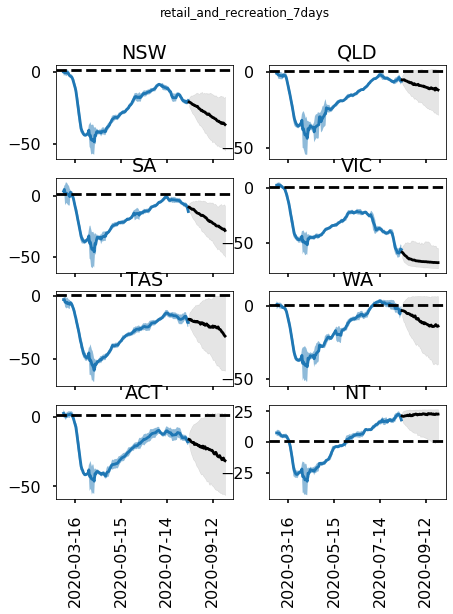

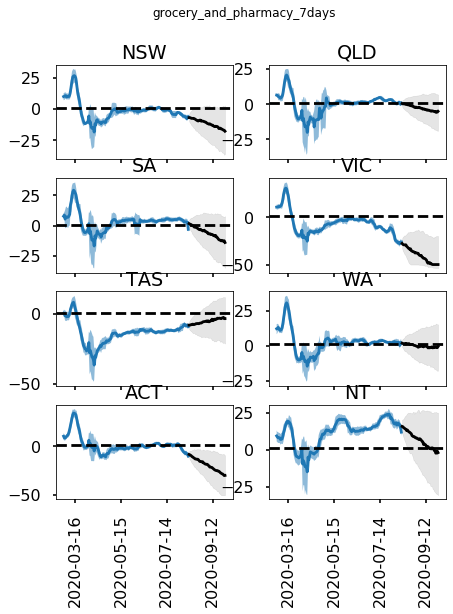

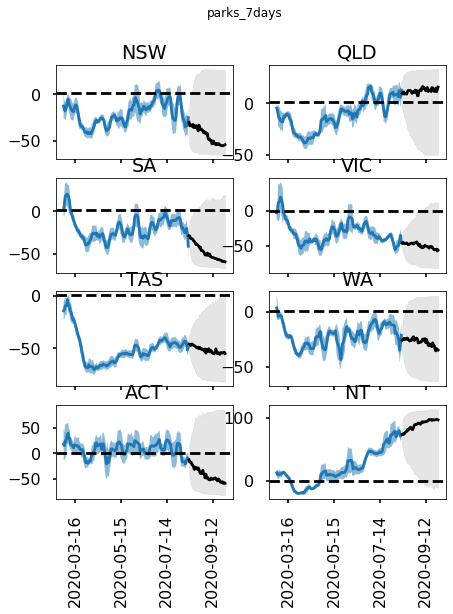

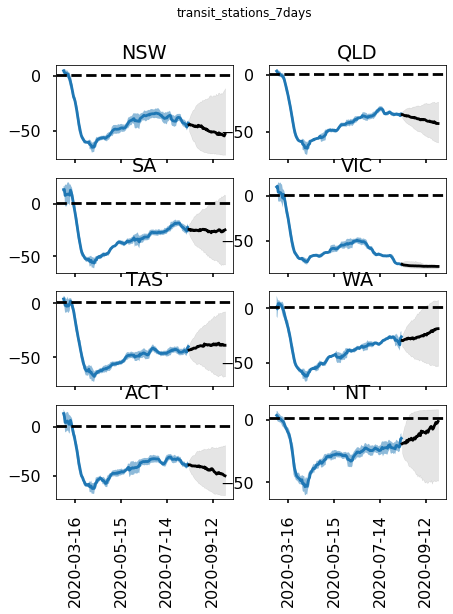

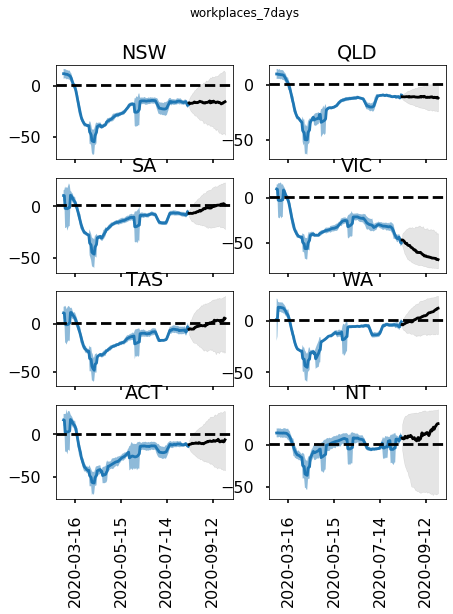

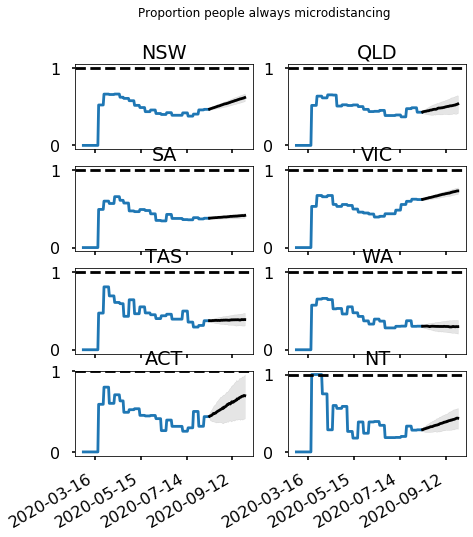

In [12]:
#forecast time parameters
n_training =28
#today = '2020-07-31'
n_forecast = 42 + (pd.to_datetime(datetime.today()) - df_google.date.values[-1]).days
print(n_forecast)
#cap = 0 #10?
training_start_date = datetime(2020,3,1,0,0)
print("Forecast ends at {} days after 1st March".format(
    pd.to_datetime("today").dayofyear + 42 - pd.to_datetime(training_start_date).dayofyear)
     )
print("Final date is {}".format(pd.to_datetime("today") + timedelta(days=42)))
df_google = df_google.loc[df_google.date>= training_start_date]
outdata = {'date': [],
           'type': [],
           'state': [],
            'mean': [],
            'std' : [],
          }
predictors = mov_values.copy()
predictors.remove('residential_7days')

mob_samples = 1000
axes = []

for var in predictors:
    
    fig, ax_states = plt.subplots(figsize=(7,8),nrows=4, ncols=2, sharex=True)
    axes.append(ax_states)
    fig.suptitle(var)
    
##extra fig for microdistancing
var='Proportion people always microdistancing'
fig, ax_states = plt.subplots(figsize=(7,8),nrows=4, ncols=2, sharex=True)
axes.append(ax_states)
fig.suptitle(var)
    
state_Rmed = {}
state_sims = {}
for i,state in enumerate(states):
    
    rownum = int(i/2.)
    colnum = np.mod(i,2)

    rows = df_google.loc[df_google.state==state].shape[0]
    #Rmed currently a list, needs to be a matrix
    Rmed_array = np.zeros(shape=(rows,len(predictors), mob_samples))
    for j, var in enumerate(predictors):
        for n in range(mob_samples):
            Rmed_array[:,j,n] = df_google[df_google['state'] == state][var].values.T + np.random.normal(loc=0,
                                                                              scale = df_google[df_google['state'] == state][var+'_std'],
                                                                             )
    dates = df_google[df_google['state'] == state]['date']
        
        #cap min and max at historical or (-50,0)
    minRmed_array = np.minimum(-50,np.amin(Rmed_array, axis = 0)) #1 by predictors by mob_samples size
    maxRmed_array = np.maximum(0,np.amax(Rmed_array, axis=0))
    sims  =  np.zeros(shape=(n_forecast,len(predictors),mob_samples)) # days by predictors by samples
    for n in range(mob_samples):
        Rmed = Rmed_array[:,:,n]
        minRmed = minRmed_array[:,n]
        maxRmed = maxRmed_array[:,n]
            
        R_diffs = np.diff(Rmed[-n_training:,:], axis=0)


        mu = np.mean(R_diffs, axis=0)
        std = np.cov(R_diffs, rowvar=False) #columns are vars, rows are obs
        sims[:,:,n] = np.minimum(maxRmed,np.mean(Rmed[-7:,:],axis=0) + np.cumsum(np.random.multivariate_normal(mu,
                                                                  std,
                                                                  size=(n_forecast)),
                                                 axis=0))#rows are sim, dates are columns
        sims[:,:,n] = np.maximum(minRmed, sims[:,:,n])
            #dates of forecast to enter
            
    dd = [dates.tolist()[-1] + timedelta(days=x) for x in range(1,n_forecast+1)]

        #     print(state)

    sims_med = np.median(sims,axis=2) #N by predictors
    sims_q25 = np.percentile(sims,25,axis=2)
    sims_q75 = np.percentile(sims,75,axis=2)
    
    
    ##forecast mircodistancing
    if state!='AUS':
        md_diffs = np.diff(prop[state].values[-n_training:])
        mu = np.mean(md_diffs)
        std = np.std(md_diffs)
        extra_days_md = pd.to_datetime(df_google.date.values[-1]).dayofyear - pd.to_datetime(
            prop[state].index.values[-1]).dayofyear
        md_sims = np.minimum(1,prop[state].values[-1] + np.cumsum(
            np.random.normal(mu,std, size=(n_forecast + extra_days_md, 1000)),
                            axis=0
        )
                            )
        md_sims = np.maximum(0, md_sims)
        #get dates
        dd_md = [prop[state].index[-1] + timedelta(days=x) for x in range(1,n_forecast+extra_days_md+1)]

    
    for j, var in enumerate(predictors+['md_prop']):
        #Record data
        axs = axes[j]
        if (state=='AUS') and (var=='md_prop'):
            continue

        if var != 'md_prop':
            outdata['type'].extend([var]*len(dd))
            outdata['state'].extend([state]*len(dd))
            outdata['date'].extend([d.strftime('%Y-%m-%d') for d in dd])
            outdata['mean'].extend(np.mean(sims[:,j,:],axis=1))
            outdata['std'].extend(np.std(sims[:,j,:],axis=1))
        else:
            outdata['type'].extend([var]*len(dd_md))
            outdata['state'].extend([state]*len(dd_md))
            outdata['date'].extend([d.strftime('%Y-%m-%d') for d in dd_md])
            outdata['mean'].extend(np.mean(md_sims,axis=1))
            
            outdata['std'].extend(np.std(md_sims,axis=1))
            
        if state in plot_states:
            if var != 'md_prop':
                axs[rownum,colnum].plot(dates,df_google[df_google['state'] == state][var].values)
                axs[rownum,colnum].fill_between(dates,
                                                np.percentile(Rmed_array[:,j,:], 25, axis =1),
                                                np.percentile(Rmed_array[:,j,:], 75, axis =1),
                                               alpha=0.5)

                axs[rownum,colnum].plot(dd,sims_med[:,j],'k')
                axs[rownum,colnum].fill_between(dd, sims_q25[:,j], sims_q75[:,j], color='k',alpha = 0.1)
            else:
                ##md plot
                axs[rownum,colnum].plot(prop[state].index,prop[state].values)
                #axs[rownum,colnum].fill_between(dates,
                #                                np.percentile(Rmed_array[:,j,:], 25, axis =1),
                #                                np.percentile(Rmed_array[:,j,:], 75, axis =1),
                #                               alpha=0.5)

                axs[rownum,colnum].plot(dd_md,np.median(md_sims,axis=1),'k')
                axs[rownum,colnum].fill_between(dd_md, np.quantile(md_sims,0.25, axis=1),
                                                np.quantile(md_sims,0.75,axis=1), color='k',alpha = 0.1)
                
            axs[rownum,colnum].set_title(state)
            axs[rownum,colnum].axhline(1,ls = '--', c = 'k')
            axs[rownum,colnum].set_title(state)
            axs[rownum,colnum].tick_params('x',rotation=90)
            axs[rownum,colnum].xaxis.set_major_locator(plt.MaxNLocator(4))
            fig.autofmt_xdate()


    state_Rmed[state] = Rmed_array
    state_sims[state] = sims


    
    
#plt.savefig('../figs/Reff_forecast_rw_training' + str(n_training) + '.pdf')

In [13]:
df_out = pd.DataFrame.from_dict(outdata)

df_md = df_out.loc[df_out.type=='md_prop']
df_out = df_out.loc[df_out.type!='md_prop']

df_forecast = pd.pivot_table(df_out, columns=['type'],index=['date','state'],values=['mean'])
df_std = pd.pivot_table(df_out, columns=['type'],index=['date','state'],values=['std'])

df_forecast_md = pd.pivot_table(df_md, columns=['state'],index=['date'],values=['mean']) 
df_forecast_md_std = pd.pivot_table(df_md, columns=['state'],index=['date'],values=['std']) 

#align with google order in columns
df_forecast = df_forecast.reindex([('mean',val) for val in predictors],axis=1)
df_std = df_std.reindex([('std',val) for val in predictors],axis=1) 
df_forecast.columns = predictors  #remove the tuple name of columns
df_std.columns = predictors


df_forecast_md = df_forecast_md.reindex([('mean',state) for state in states],axis=1)
df_forecast_md_std = df_forecast_md_std.reindex([('std',state) for state in states],axis=1)

df_forecast_md.columns = states
df_forecast_md_std.columns = states

df_forecast = df_forecast.reset_index() 
df_std = df_std.reset_index()

df_forecast_md = df_forecast_md.reset_index()
df_forecast_md_std = df_forecast_md_std.reset_index() 

df_forecast.date = pd.to_datetime(df_forecast.date)
df_std.date = pd.to_datetime(df_std.date)

df_forecast_md.date = pd.to_datetime(df_forecast_md.date)
df_forecast_md_std.date = pd.to_datetime(df_forecast_md_std.date)



In [14]:
df_R = df_google[['date','state']+mov_values + [val+'_std' for val in mov_values]] 
df_R = pd.concat([df_R,df_forecast],ignore_index=True,sort=False)
df_R['policy'] = (df_R.date>='2020-03-20').astype('int8')

df_R.tail()

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days,residential_7days,retail_and_recreation_7days_std,grocery_and_pharmacy_7days_std,parks_7days_std,transit_stations_7days_std,workplaces_7days_std,residential_7days_std,policy
1855,2020-09-28,QLD,-15.717411,-5.585979,-1.845404,-40.497072,-11.679558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1856,2020-09-28,SA,-28.226866,-12.195570,-30.422205,-22.734604,-0.833461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1857,2020-09-28,TAS,-32.345338,-6.413524,-45.087401,-36.073146,-1.224732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1858,2020-09-28,VIC,-58.836599,-35.943651,-34.270810,-75.947076,-55.312436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1859,2020-09-28,WA,-18.641365,-1.318336,-25.744124,-22.958972,4.667041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


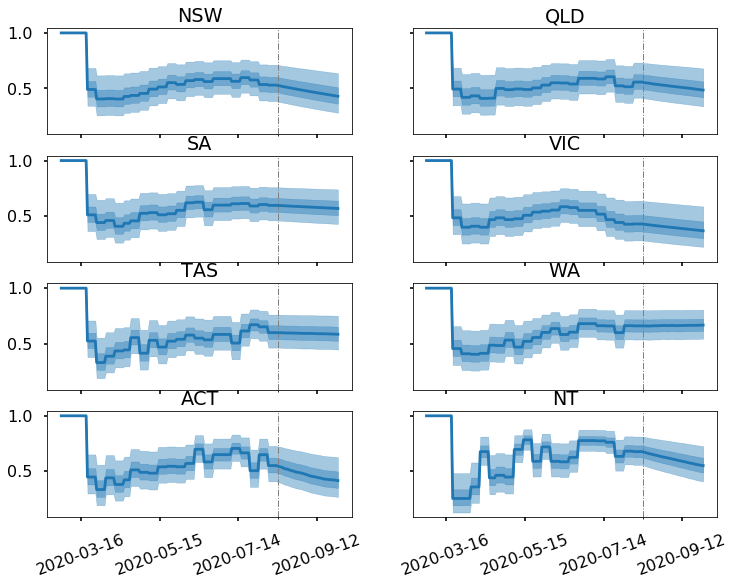

In [15]:
from scipy.special import expit

df_md = pd.concat([prop,df_forecast_md.set_index('date')])
#prop_std = pd.DataFrame(np.random.beta(1+survey_counts, 1+survey_respond), columns = survey_counts.columns, index = prop.index)

#df_md_std = pd.concat([prop_std,df_forecast_md_std.set_index('date')])

expo_decay=True
theta_md = np.tile(df_samples['theta_md'].values, (df_md['NSW'].shape[0],1))

fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)

for i,state in enumerate(plot_states):
    prop_sim= df_md[state].values#np.random.normal(df_md[state].values, df_md_std.values)
    if expo_decay:
        md = ((1+theta_md).T**(-1* prop_sim)).T
    else:
        md = (2*expit(-1*theta_md*prop_sim[:,np.newaxis]))
        
    
    row = i//2
    col = i%2
    
    ax[row,col].plot(df_md[state].index, np.median(md,axis=1 ), label='Microdistancing')
    ax[row,col].fill_between(df_md[state].index, np.quantile(md,0.25,axis=1 ),np.quantile(md,0.75,axis=1 ),
                             label='Microdistancing',
                            alpha=0.4,
                            color='C0')
    ax[row,col].fill_between(df_md[state].index, np.quantile(md,0.05,axis=1 ),np.quantile(md,0.95,axis=1 ),
                             label='Microdistancing',
                            alpha=0.4,
                            color='C0')
    ax[row,col].set_title(state)
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    
    ax[row,col].set_xticks([df_md[state].index.values[-n_forecast-extra_days_md]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
    
    
plt.show()

In [17]:
#generate posterior estimates of each state
from scipy.special import expit
df_R = df_R.sort_values('date')
n_samples = 100
samples = df_samples.sample(n_samples) #test on sample of 2
forecast_type = ['R_L','R_L0']
state_Rs = {
    'state':[],
    'date':[],
    'type':[],
    'median':[],
    'lower':[],
    'upper':[],
    'bottom':[],
    'top':[],
    'mean':[],
    'std':[],
}
ban = '2020-03-20'
new_pol = '2020-06-01' #VIC and NSW allow gatherings of up to 20 people, other jurisdictions allow for 

expo_decay=True

typ_state_R={}
mob_forecast_date = df_forecast.date.min()
mob_samples = 100
print("forecast mobility from "+str(mob_forecast_date))
for typ in forecast_type:
    state_R={}
    for state in states:
    #sort df_R by date so that rows are dates

        #rows are dates, columns are predictors
        df_state = df_R.loc[df_R.state==state]
        dd = df_state.date
        post_values = samples[predictors].values.T
        prop_sim = df_md[state].values
        
                    #take right size of md to be N by N
        theta_md = np.tile(samples['theta_md'].values, (df_state.shape[0],mob_samples))
        if expo_decay:
            md = ((1+theta_md).T**(-1* prop_sim)).T
        else:
            md = (2*expit(-1*theta_md*prop_sim[:,np.newaxis]))
        
        for n in range(mob_samples):
            #add gaussian noise to predictors before forecast
            df_state.loc[df_state.date<mob_forecast_date,predictors] = state_Rmed[state][:,:,n]/100#df_state.loc[
                #df_state.date<mob_forecast_date,predictors]/100 + np.random.normal(
                #loc= 0, scale = df_state.loc[
                #    (df_state.date<mob_forecast_date),
                #    [val+'_std' for val in predictors]].values/100)

            
            #add gaussian noise to predictors after forecast
            df_state.loc[df_state.date>=mob_forecast_date,predictors] = state_sims[state][:,:,n]/100
            #df_state.loc[
             #   df_state.date>=mob_forecast_date,predictors]/100 + np.random.normal(
             #   loc= 0, scale = df_std.loc[(df_std.state==state,predictors)].values/100)

            
            #dd = df_state.date

            df1 =df_state.loc[df_state.date<=ban]
            X1 = df1[predictors] #N by K
            
            
            sim_R = np.tile(samples.R_L.values, (df_state.shape[0],mob_samples))


            #set initial pre ban values of md to 1
            md[:X1.shape[0],:] = 1

            if n==0:
                #initialise arrays (loggodds)
                logodds = X1 @ post_values # N by K times (Nsamples by K )^T = Ndate by Nsamples
                
                if typ =='R_L':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]
                    X3 = df3[predictors]

                    #halve effect of md
                    #md[(X1.shape[0]+df2.shape[0]):,:] = 1- 0.5 *( 1 - md[(X1.shape[0]+df2.shape[0]):,:])
                    
                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                    logodds = np.append(logodds,X3 @ post_values,axis=0)
                    
                    #md = np.append(md, ((1+theta_md).T**(-1* prop2)).T, axis=0)
                    #md = np.append(md, ((1+theta_md).T**(-1* prop3)).T, axis=0)

                elif typ=='R_L0':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = np.zeros_like(df2[predictors])
                    X3 = np.zeros_like(df3[predictors])
                    
                    logodds = np.zeros_like(logodds)
                    #social mobility all at baseline implies R_l = R_L0

                    #md has no effect after June 1st
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                    logodds = np.append(logodds,X3 @ post_values,axis=0)


                else:
                    #forecast as before, no changes to md
                    df2 = df_state.loc[df_state.date>ban]
                    X2 = df2[predictors]

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                                    #df_state.loc[df_state.date>'2020-03-15',predictors].values/100 @ samples[predictors].values.T, axis = 0)

            else:
                #concatenate to pre-existing logodds martrix
                logodds1 = X1 @ post_values
                
                if typ =='R_L':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]
                    X3 = df3[predictors]
                    
                    prop2 = df_md.loc[ban:new_pol,state].values
                    prop3 = df_md.loc[new_pol:,state].values

                    #halve effect of md
                    #md[(X1.shape[0]+df2.shape[0]):,:] = 1- 0.5 *( 1 - md[(X1.shape[0]+df2.shape[0]):,:])

                    logodds2 = X2 @ post_values
                    logodds3 = X3 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                    logodds_sample = np.append(logodds_sample, logodds3, axis=0)

                elif typ=='R_L0':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = np.zeros_like(df2[predictors])
                    X3 = np.zeros_like(df3[predictors])
                    
                    logodds1 = np.zeros_like(logodds1)
                    #social mobility all at baseline implies R_l = R_L0

                    #md has no effect after June 1st
                    
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1
                    
                    logodds2 = X2 @ post_values
                    logodds3 = X3 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                    logodds_sample = np.append(logodds_sample, logodds3, axis=0)


                else:
                    #forecast as before, no changes to md
                    df2 = df_state.loc[df_state.date>ban]
                    X2 = df2[predictors]

                    logodds2 = X2 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                
                ##concatenate to previous
                logodds = np.concatenate((logodds, logodds_sample ), axis =1)

        R_L = 2* md *sim_R * expit( logodds ) 

        R_L_lower = np.percentile(R_L,25,axis=1)
        R_L_upper = np.percentile(R_L,75,axis=1)

        R_L_bottom = np.percentile(R_L,5,axis=1)
        R_L_top = np.percentile(R_L,95,axis=1)


        R_L_med = np.median(R_L,axis=1)

        #R_L
        state_Rs['state'].extend([state]*df_state.shape[0])
        state_Rs['type'].extend([typ]*df_state.shape[0])
        state_Rs['date'].extend(dd.values) #repeat n_samples times?
        state_Rs['lower'].extend(R_L_lower)
        state_Rs['median'].extend(R_L_med)
        state_Rs['upper'].extend(R_L_upper)
        state_Rs['top'].extend(R_L_top)
        state_Rs['bottom'].extend(R_L_bottom)
        state_Rs['mean'].extend(np.mean(R_L,axis=1))
        state_Rs['std'].extend(np.std(R_L,axis=1))
        
        state_R[state] = R_L
    typ_state_R[typ] = state_R
    
    
    
for state in states:
    #R_I
    R_I = samples['R_I'].values[:df_state.shape[0]]
    
    
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['R_I']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(np.repeat(np.percentile(R_I,25),df_state.shape[0]))
    state_Rs['median'].extend(np.repeat(np.median(R_I),df_state.shape[0]))
    state_Rs['upper'].extend(np.repeat(np.percentile(R_I,75),df_state.shape[0]))
    state_Rs['top'].extend(np.repeat(np.percentile(R_I,95),df_state.shape[0]))
    state_Rs['bottom'].extend(np.repeat(np.percentile(R_I,5),df_state.shape[0]))
    state_Rs['mean'].extend(np.repeat(np.mean(R_I),df_state.shape[0]))
    state_Rs['std'].extend(np.repeat(np.std(R_I),df_state.shape[0]))
    
    
    

forecast mobility from 2020-08-12 00:00:00


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
df_Rhats = pd.DataFrame().from_dict(state_Rs)
df_Rhats = df_Rhats.set_index(['state','date','type'])

d = pd.DataFrame()
for state in states:
    for i,typ in enumerate(forecast_type):
        if i==0:
            t = pd.DataFrame.from_dict(typ_state_R[typ][state])
            t['date'] = dd.values
            t['state'] = state
            t['type'] = typ
        else:
            temp = pd.DataFrame.from_dict(typ_state_R[typ][state])
            temp['date'] = dd.values
            temp['state'] = state
            temp['type'] = typ
            t = t.append(temp)   
    #R_I
    i = pd.DataFrame(np.tile(samples['R_I'].values,(len(dd.values),100)))
    i['date'] = dd.values
    i['type'] = 'R_I'
    i['state'] = state

    t = t.append(i)
        
    d = d.append(t)
        
        #df_Rhats = df_Rhats.loc[(df_Rhats.state==state)&(df_Rhats.type=='R_L')].join( t)

d = d.set_index(['state','date','type'])
df_Rhats = df_Rhats.join(d)
df_Rhats = df_Rhats.reset_index()
df_Rhats.state = df_Rhats.state.astype(str)
df_Rhats.type = df_Rhats.type.astype(str)

In [19]:

df_Rhats

,state,date,type,median,lower,upper,bottom,top,mean,std,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,NSW,2020-03-01,R_L,1.466478,1.126155,1.805475,0.742308,2.361188,1.488754,0.497947,...,2.279215,2.465711,2.017740,1.995602,1.707157,1.943517,1.901173,2.004018,2.144628,2.097904
1,NSW,2020-03-02,R_L,1.499759,1.222089,1.744419,0.802509,2.091560,1.477838,0.387382,...,0.882177,1.008106,0.760878,0.744772,0.841977,1.406714,0.575181,0.538866,0.916596,0.836956
2,NSW,2020-03-03,R_L,1.386341,1.134053,1.663927,0.818015,2.056957,1.405773,0.378326,...,1.979774,2.236350,1.672010,1.664907,1.359841,1.720482,1.509569,1.581431,1.683556,1.768845
3,NSW,2020-03-04,R_L,1.480565,1.190360,1.710888,0.835065,2.100509,1.463620,0.385575,...,1.384370,1.536558,1.227595,1.232793,1.202603,1.647850,1.066905,1.060494,1.435721,1.352527
4,NSW,2020-03-05,R_L,1.518831,1.272775,1.777065,0.965902,2.150923,1.533142,0.366840,...,1.421655,1.569556,1.345293,1.242711,1.128730,1.895556,1.007262,1.204859,1.791365,1.540036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5083,NT,2020-09-24,R_I,0.067552,0.054853,0.075761,0.039811,0.086787,0.065740,0.014872,...,0.053596,0.076456,0.068646,0.086645,0.062887,0.062318,0.089053,0.070972,0.045499,0.047052
5084,NT,2020-09-25,R_I,0.067552,0.054853,0.075761,0.039811,0.086787,0.065740,0.014872,...,0.053596,0.076456,0.068646,0.086645,0.062887,0.062318,0.089053,0.070972,0.045499,0.047052
5085,NT,2020-09-26,R_I,0.067552,0.054853,0.075761,0.039811,0.086787,0.065740,0.014872,...,0.053596,0.076456,0.068646,0.086645,0.062887,0.062318,0.089053,0.070972,0.045499,0.047052
5086,NT,2020-09-27,R_I,0.067552,0.054853,0.075761,0.039811,0.086787,0.065740,0.014872,...,0.053596,0.076456,0.068646,0.086645,0.062887,0.062318,0.089053,0.070972,0.045499,0.047052


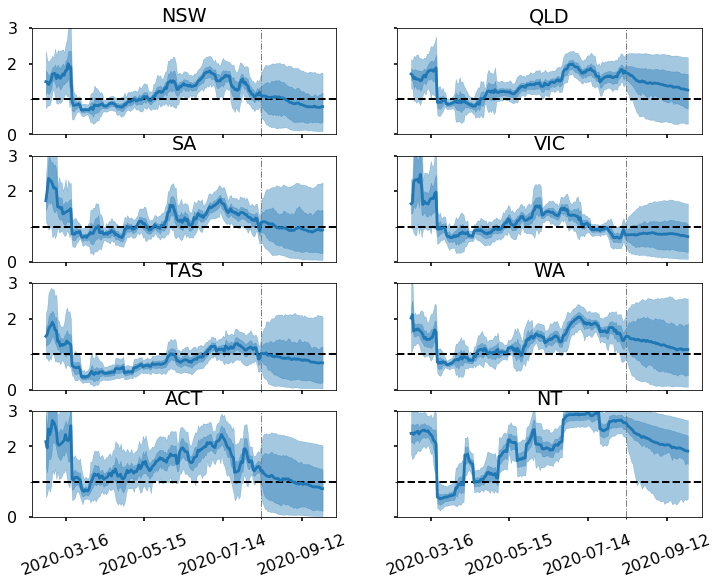

In [20]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='R_L')]
    
    ax[row,col].plot(plot_df.date, plot_df['mean'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,2,3],minor=False)
    ax[row,col].set_yticklabels([0,2,3],minor=False)
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,3))
    
    ax[row,col].set_xticks([plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
#fig.autofmt_xdate()
plt.savefig("../figs/soc_mob_R_L_hats.pdf")    
plt.show()

In [13]:
df_Rhats = df_Rhats[['state','date','type','median','bottom','lower','upper','top']+[i for i in range(1000)]
                    #+[3*i+mob_samples*i for i in range(mob_samples)]
                   ]
df_Rhats.columns = ['state','date','type','median','bottom','lower','upper','top'] + [i for i in range(1000)]
df_Rhats

,state,date,type,median,bottom,lower,upper,top,0,1,...,990,991,992,993,994,995,996,997,998,999
0,NSW,2020-03-01,R_L,1.590328,0.764109,1.273961,1.977400,2.548922,1.528229,1.369231,...,1.403288,1.532830,1.511736,1.690193,1.612123,1.532650,1.635190,1.428249,1.580017,1.674441
1,NSW,2020-03-02,R_L,1.437205,0.856764,1.210896,1.678561,2.105920,1.885524,1.672560,...,1.311947,1.415619,1.252444,1.366256,1.164912,1.180492,1.177980,1.198960,1.207498,1.127886
2,NSW,2020-03-03,R_L,1.428599,0.810916,1.179477,1.649733,1.988984,1.042186,0.977398,...,1.720350,1.960686,1.750457,1.871206,1.832847,1.664783,1.785642,1.997441,1.686891,1.708780
3,NSW,2020-03-04,R_L,1.515649,0.872590,1.242937,1.791272,2.161036,1.221777,1.215679,...,1.560899,1.736096,1.563259,1.730079,1.660538,1.406044,1.495739,1.876725,1.433982,1.510051
4,NSW,2020-03-05,R_L,1.566756,0.986596,1.327257,1.817932,2.335492,1.610166,1.592065,...,1.543400,1.760926,1.583438,1.746467,1.536312,1.423593,1.431607,1.912989,1.474551,1.381870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,NT,2020-09-17,R_I,0.065175,0.039379,0.055162,0.072697,0.081297,0.053605,0.079384,...,0.043723,0.048132,0.039117,0.075652,0.072063,0.071830,0.068780,0.082372,0.064602,0.073709
4916,NT,2020-09-18,R_I,0.065175,0.039379,0.055162,0.072697,0.081297,0.053605,0.079384,...,0.043723,0.048132,0.039117,0.075652,0.072063,0.071830,0.068780,0.082372,0.064602,0.073709
4917,NT,2020-09-19,R_I,0.065175,0.039379,0.055162,0.072697,0.081297,0.053605,0.079384,...,0.043723,0.048132,0.039117,0.075652,0.072063,0.071830,0.068780,0.082372,0.064602,0.073709
4918,NT,2020-09-20,R_I,0.065175,0.039379,0.055162,0.072697,0.081297,0.053605,0.079384,...,0.043723,0.048132,0.039117,0.075652,0.072063,0.071830,0.068780,0.082372,0.064602,0.073709


In [14]:
from datetime import datetime
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')
df_hdf = df_Rhats.loc[df_Rhats.type=='R_L']
df_hdf = df_hdf.append(df_Rhats.loc[(df_Rhats.type=='R_I')&(df_Rhats.date=='2020-03-01')])
df_hdf = df_hdf.append(df_Rhats.loc[(df_Rhats.type=='R_L0')&(df_Rhats.date=='2020-03-01')])
#df_Rhats.to_csv('./soc_mob_R'+today+'.csv')

#since strings data types have variable length, it is by default stored as object dtype.
#change to string data type
#df_hdf['state'] = df_hdf['state'].astype('|S80')
#df_hdf['type'] = df_hdf['type'].astype('|S80')

df_hdf.to_hdf('../data/soc_mob_R'+today+'.h5',key='Reff')


/anaconda3/lib/python3.6/site-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/anaconda3/lib/python3.6/site-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_items] [items->None]

  f(store)


In [15]:
df_hdf

,state,date,type,median,bottom,lower,upper,top,0,1,...,990,991,992,993,994,995,996,997,998,999
0,NSW,2020-03-01,R_L,1.590328,0.764109,1.273961,1.977400,2.548922,1.528229,1.369231,...,1.403288,1.532830,1.511736,1.690193,1.612123,1.532650,1.635190,1.428249,1.580017,1.674441
1,NSW,2020-03-02,R_L,1.437205,0.856764,1.210896,1.678561,2.105920,1.885524,1.672560,...,1.311947,1.415619,1.252444,1.366256,1.164912,1.180492,1.177980,1.198960,1.207498,1.127886
2,NSW,2020-03-03,R_L,1.428599,0.810916,1.179477,1.649733,1.988984,1.042186,0.977398,...,1.720350,1.960686,1.750457,1.871206,1.832847,1.664783,1.785642,1.997441,1.686891,1.708780
3,NSW,2020-03-04,R_L,1.515649,0.872590,1.242937,1.791272,2.161036,1.221777,1.215679,...,1.560899,1.736096,1.563259,1.730079,1.660538,1.406044,1.495739,1.876725,1.433982,1.510051
4,NSW,2020-03-05,R_L,1.566756,0.986596,1.327257,1.817932,2.335492,1.610166,1.592065,...,1.543400,1.760926,1.583438,1.746467,1.536312,1.423593,1.431607,1.912989,1.474551,1.381870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2255,VIC,2020-03-01,R_L0,2.138945,1.761072,2.012507,2.330215,2.533913,2.022603,1.911276,...,2.037615,2.398013,2.111210,2.369211,2.303893,2.018158,2.209363,2.784972,2.061508,2.154153
2460,TAS,2020-03-01,R_L0,2.138945,1.761072,2.012507,2.330215,2.533913,2.022603,1.911276,...,2.037615,2.398013,2.111210,2.369211,2.303893,2.018158,2.209363,2.784972,2.061508,2.154153
2665,WA,2020-03-01,R_L0,2.138945,1.761072,2.012507,2.330215,2.533913,2.022603,1.911276,...,2.037615,2.398013,2.111210,2.369211,2.303893,2.018158,2.209363,2.784972,2.061508,2.154153
2870,ACT,2020-03-01,R_L0,2.138945,1.761072,2.012507,2.330215,2.533913,2.022603,1.911276,...,2.037615,2.398013,2.111210,2.369211,2.303893,2.018158,2.209363,2.784972,2.061508,2.154153


# Interpretation
Exmaine what macro and micro distancing means in regards to baseline and current values.

In [14]:
# Plot logistic function over time

ban = '2020-03-20'
for state in states:
#sort df_R by date so that rows are dates
    df_state = df_R.loc[df_R.state==state]
    
    
    post_values = samples[predictors].values.T
    dd = df_state.date
    
    df1 =df_state.loc[df_state.date<=ban]
    df2 = df_state.loc[df_state.date>ban]
    X1 = df1[predictors]/100 #N by K
    X2 = df2[predictors]/100
    logodds = X1 @ post_values # N by K times (Nsamples by K )^T = N by N
    md = samples['md'].values.copy()
    
    #logodds = df_state.loc[df_state.date<='2020-03-15',predictors].values/100 @ samples[predictors].values.T #row is a date, column is a posterior sample
    md[:logodds.shape[0]] = 1
    
    logodds = np.append(logodds,X2 @ post_values,axis=0)
                        #df_state.loc[df_state.date>'2020-03-15',predictors].values/100 @ samples[predictors].values.T, axis = 0)
    factor = 2* md* expit( logodds ) 
    
    
    factor_lower = np.percentile(factor,25,axis=1)
    factor_upper = np.percentile(factor,75,axis=1)
    
    factor_bottom = np.percentile(factor,5,axis=1)
    factor_top = np.percentile(factor,95,axis=1)

    
    factor_med = np.median(factor,axis=1)
    
    #factor
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['factor']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(factor_lower)
    state_Rs['median'].extend(factor_med)
    state_Rs['upper'].extend(factor_upper)
    state_Rs['top'].extend(factor_top)
    state_Rs['bottom'].extend(factor_bottom)
    state_Rs['mean'].extend(np.mean(factor,axis=1))
    state_Rs['std'].extend(np.std(factor,axis=1))
    
    #now do without microdistnacing
    no_md = 2*expit(logodds)
    factor = no_md
    factor_lower = np.percentile(factor,25,axis=1)
    factor_upper = np.percentile(factor,75,axis=1)
    
    factor_bottom = np.percentile(factor,5,axis=1)
    factor_top = np.percentile(factor,95,axis=1)

    
    factor_med = np.median(factor,axis=1)
    
    #no md
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['no_md']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(factor_lower)
    state_Rs['median'].extend(factor_med)
    state_Rs['upper'].extend(factor_upper)
    state_Rs['top'].extend(factor_top)
    state_Rs['bottom'].extend(factor_bottom)
    state_Rs['mean'].extend(np.mean(factor,axis=1))
    state_Rs['std'].extend(np.std(factor,axis=1))

    
df_Rhats = pd.DataFrame().from_dict(state_Rs)

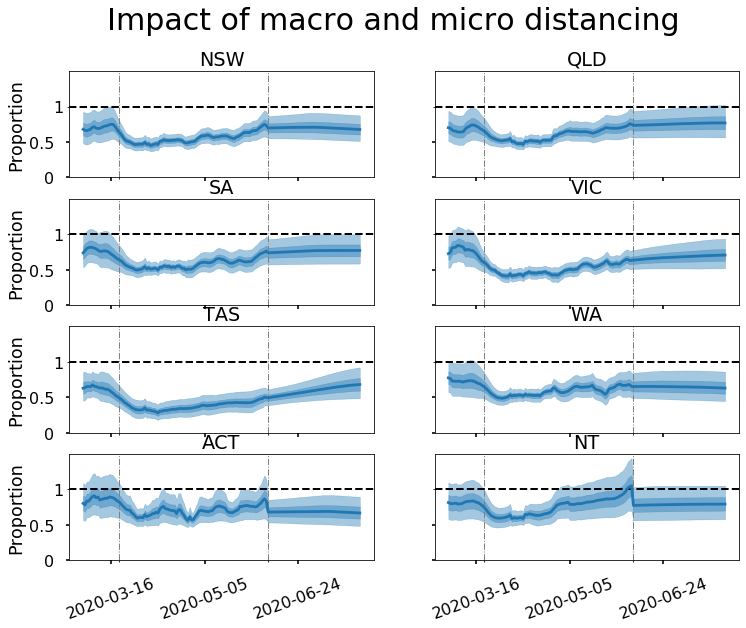

In [15]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='factor')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,0.5],minor=False)
    ax[row,col].set_yticklabels([0,0.5],minor=False)
    ax[row,col].set_yticklabels([1],minor=True)
    
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,1.5))
    
    ax[row,col].set_xticks([ban,plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
    
    if col==0:
        ax[row,col].set_ylabel('Proportion')
    
#fig.autofmt_xdate()
fig.suptitle("Impact of macro and micro distancing", fontsize=30)
plt.savefig("./figs/distance_impact.pdf")    
plt.show()

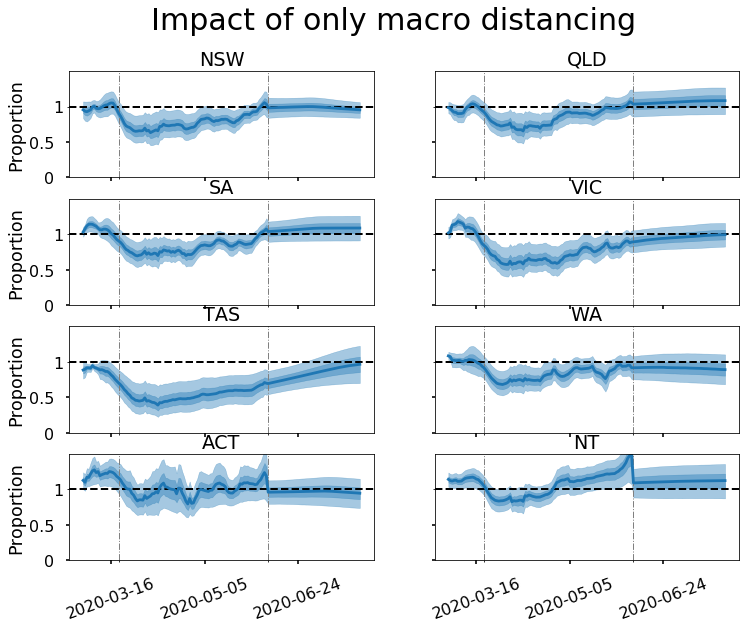

In [16]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='no_md')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,0.5],minor=False)
    ax[row,col].set_yticklabels([0,0.5],minor=False)
    ax[row,col].set_yticklabels([1],minor=True)
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,1.5))
    
    ax[row,col].set_xticks([ban,plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
    if col==0:
        ax[row,col].set_ylabel('Proportion')
#fig.autofmt_xdate()
fig.suptitle("Impact of only macro distancing", fontsize=30)
plt.savefig("./figs/macro.pdf")    
plt.show()

## Effect of distancing on $R_L$

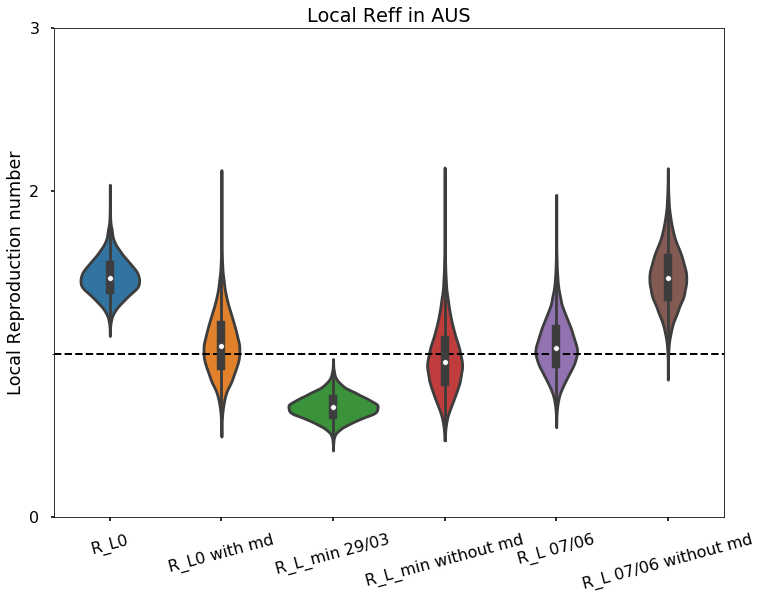

In [17]:
import seaborn as sns
df_samples['R_L0'] = samples.R_L
df_samples['R_L0 with md'] = samples.R_L * samples.md

##take lowest point in NSW data
min_row = df_Rhats.loc[(df_Rhats.state=='AUS') & 
                       (df_Rhats.type=='factor'),'mean'].values.argmin()

min_date= df_Rhats.iloc[min_row].date #29th March
X = df_R.loc[(df_R.date==min_date)&(df_R.state=='AUS'),predictors].values/100 #predictors
    
post_values = samples[predictors].values.T #K by 1000

min_RL = 2*samples.R_L.values*samples.md.values*expit(X @ post_values) # 1 by K times K 1000
min_RL_nomd = 2*samples.R_L.values*expit(X @ post_values) # 1 by K times K 1000
df_samples['R_L_min 29/03'] = min_RL.flatten()
df_samples['R_L_min without md'] = min_RL_nomd.flatten()

#Take last Google index, 21st May
last_date = df_google.date.values[-1]
last_date_str = pd.to_datetime(str(last_date)).strftime('%d/%m')
X = df_R.loc[(df_R.date==last_date)&(df_R.state=='AUS'),predictors].values/100 #predictors
    

post_values = samples[predictors].values.T #K by 1000

last_RL = 2*samples.R_L.values*samples.md.values*expit(X @ post_values) # 1 by K times K 1000
last_RL_nomd = 2*samples.R_L.values*expit(X @ post_values) # 1 by K times K 1000
df_samples['R_L '+last_date_str] = last_RL.flatten()
df_samples['R_L '+last_date_str+' without md'] = last_RL_nomd.flatten()

plot_df = pd.melt(df_samples[
    ['R_L0','R_L0 with md','R_L_min 29/03', 
     'R_L_min without md', 'R_L '+last_date_str,'R_L '+last_date_str+' without md']
])


fig,ax = plt.subplots(figsize=(12,9))
sns.violinplot(
        x='variable',
        y='value',
        data = plot_df,
        ax=ax,
    cut=0,
)
ax.set_title("Local Reff in AUS")
ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_ylabel('Local Reproduction number')
ax.set_xlabel('')
ax.tick_params('x', rotation=15)
ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.savefig('./figs/Local.pdf')
plt.show()

NSW
retail_and_recreation_7days    0.785147
grocery_and_pharmacy_7days     0.943081
parks_7days                    0.765646
transit_stations_7days         1.124297
workplaces_7days               1.033505
dtype: float64
VIC
retail_and_recreation_7days    0.770999
grocery_and_pharmacy_7days     0.905317
parks_7days                    0.736568
transit_stations_7days         1.142369
workplaces_7days               1.036765
dtype: float64
QLD
retail_and_recreation_7days    0.823989
grocery_and_pharmacy_7days     0.947991
parks_7days                    0.811257
transit_stations_7days         1.117864
workplaces_7days               1.026356
dtype: float64


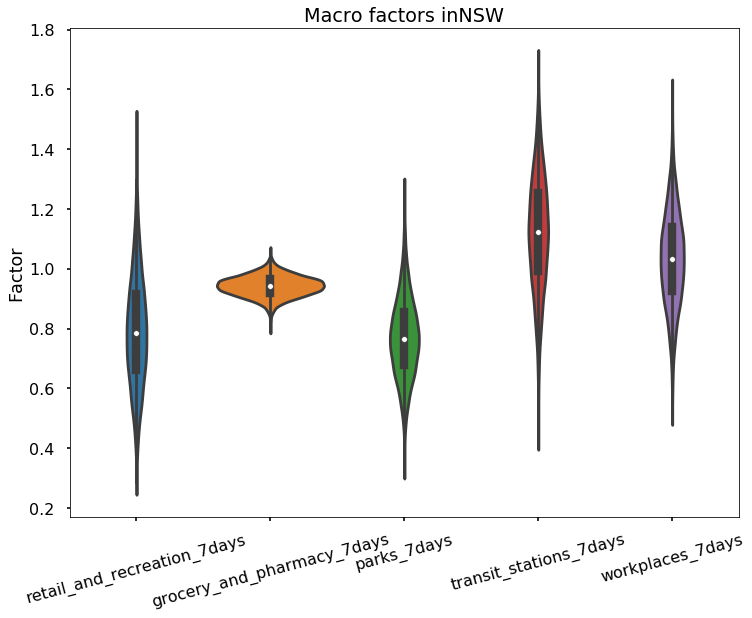

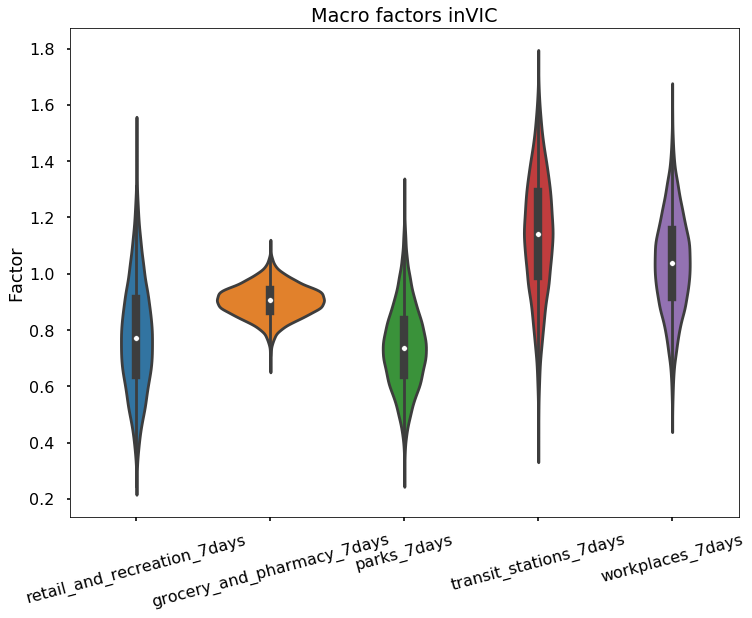

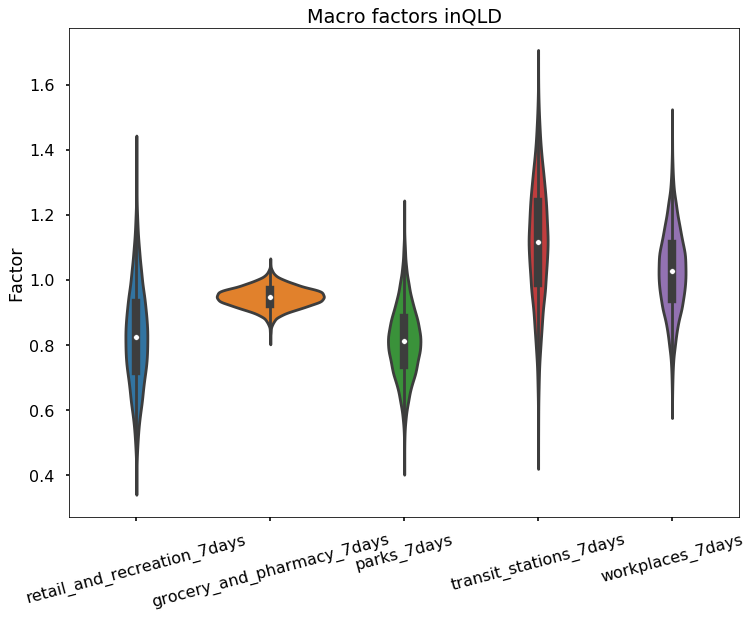

In [18]:
### Impact of individual parts
#Take last Google index, 21st May
for state in ['NSW','VIC','QLD']:
    single_pred = {}

    for i,pred in enumerate(predictors):
        X = df_R.loc[(df_R.date=='2020-03-29')&(df_R.state==state),pred].values/100 #predictors


        post_values = samples[pred].values.T #K by 1000


        last_RL_nomd = 2*expit(X * post_values) # 1 by K times K 1000
        single_pred[pred]= last_RL_nomd.flatten()

    plot_df = pd.melt(pd.DataFrame.from_dict(single_pred))
    print(state)
    print(pd.DataFrame.from_dict(single_pred).median())
    fig,ax = plt.subplots(figsize=(12,9))
    sns.violinplot(
            x='variable',
            y='value',
            data = plot_df,
            ax=ax,
        cut=1,
    )

    ax.set_title("Macro factors in" +state)
    ax.set_yticks([1],minor=True,)
    #ax.set_yticks([0,2,3],minor=False)
    ax.set_ylabel('Factor')
    ax.set_xlabel('')
    ax.tick_params('x', rotation=15)
    ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.show()

In [308]:
df_R.loc[df_R.date=='2020-03-23']

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days,policy
755,2020-05-23,AUS,-24.571429,-0.285714,-24.571429,-45.857143,-20.428571,1
754,2020-05-23,TAS,-30.857143,-13.142857,-55.142857,-48.714286,-15.000000,1
753,2020-05-23,ACT,-26.285714,-1.428571,7.285714,-43.142857,-23.000000,1
752,2020-05-23,SA,-19.285714,4.714286,-20.571429,-35.428571,-12.142857,1
751,2020-05-23,VIC,-31.000000,-2.857143,-24.714286,-56.142857,-28.142857,1
750,2020-05-23,QLD,-19.000000,2.000000,-10.428571,-44.714286,-15.000000,1
749,2020-05-23,NSW,-25.857143,-0.571429,-29.285714,-44.714286,-22.142857,1
748,2020-05-23,WA,-19.857143,1.428571,-38.714286,-45.285714,-12.285714,1
747,2020-05-23,NT,-3.000000,20.571429,11.571429,-27.714286,6.000000,1


In [40]:
min_RL = 2*df_samples.md.values*expit(X @ post_values) # 1 by K times K 1000
2*df_samples.md.values*expit(X @ post_values)

array([[0.40029017, 0.55652395, 0.44423486, ..., 0.32070831, 0.31617324,
        0.30867425]])

In [42]:
min_RL = 2*df_samples.md.values*expit(X @ post_values)

In [44]:
min_RL.shape

(1, 10000)